In [1]:
# Import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# For inline plotting in Jupyter
%matplotlib inline

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Examine the website structure
url = "http://books.toscrape.com/"
print(f"Scraping URL: {url}")

# Make a test request to see if the site is accessible
test_response = requests.get(url, timeout=10)
print(f"Response Status: {test_response.status_code}")

Scraping URL: http://books.toscrape.com/
Response Status: 200


In [3]:
def scrape_books_from_page(url):
    """
    Scrape book data from a single page
    """
    books_data = []
    
    try:
        # Send HTTP request
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for bad status codes
        
        # Parse HTML content
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find all book containers
        books = soup.find_all('article', class_='product_pod')
        
        for book in books:
            try:
                # Extract title
                title_tag = book.find('h3').find('a')
                title = title_tag.get('title', 'No Title')
                
                # Extract price
                price_tag = book.find('p', class_='price_color')
                price_text = price_tag.get_text(strip=True) if price_tag else '£0.00'
                
                # Extract rating
                rating_tag = book.find('p', class_='star-rating')
                rating_class = rating_tag.get('class', [''])[1] if rating_tag else 'Zero'
                
                # Extract availability
                availability_tag = book.find('p', class_='instock availability')
                availability = availability_tag.get_text(strip=True) if availability_tag else 'Not Available'
                
                books_data.append({
                    'Title': title,
                    'Price': price_text,
                    'Rating': rating_class,
                    'Availability': availability
                })
                
            except Exception as e:
                print(f"Error processing a book: {e}")
                continue
                
    except requests.RequestException as e:
        print(f"Error accessing {url}: {e}")
    except Exception as e:
        print(f"Error parsing page: {e}")
    
    return books_data

# Scrape books from the homepage
print("Scraping books from homepage...")
books_data = scrape_books_from_page("http://books.toscrape.com/")
print(f"Successfully scraped {len(books_data)} books")

Scraping books from homepage...
Successfully scraped 20 books


In [4]:
def scrape_all_books(max_pages=5):
    """
    Scrape books from multiple pages
    """
    all_books = []
    base_url = "http://books.toscrape.com/catalogue/page-{}.html"
    
    for page_num in range(1, max_pages + 1):
        if page_num == 1:
            url = "http://books.toscrape.com/"
        else:
            url = base_url.format(page_num)
        
        print(f"Scraping page {page_num}...")
        page_books = scrape_books_from_page(url)
        all_books.extend(page_books)
        
        # Be respectful - add a small delay
        import time
        time.sleep(1)  # 1 second delay between requests
    
    return all_books

# Scrape from multiple pages (adjust max_pages as needed)
print("\n" + "="*50)
print("Scraping from multiple pages...")
all_books = scrape_all_books(max_pages=3)  # Start with 3 pages, you can increase
print(f"Total books scraped: {len(all_books)}")


Scraping from multiple pages...
Scraping page 1...
Scraping page 2...
Scraping page 3...
Total books scraped: 60


In [5]:
# Create DataFrame
df = pd.DataFrame(all_books)

# Display initial data
print("Initial DataFrame Info:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

# Clean the data

# 1. Convert prices from strings to numerical values
def clean_price(price_str):
    """Extract numerical value from price string"""
    try:
        # Remove £ symbol and convert to float
        price = float(re.sub(r'[^\d.]', '', price_str))
        return price
    except:
        return 0.0

df['Price_Clean'] = df['Price'].apply(clean_price)

# 2. Map ratings to numerical values
rating_mapping = {
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5,
    'Zero': 0
}

df['Rating_Numeric'] = df['Rating'].map(rating_mapping)

# Display cleaned data
print("\n" + "="*50)
print("DATA AFTER CLEANING")
print("="*50)
print("\nPrice Statistics:")
print(f"Min Price: £{df['Price_Clean'].min():.2f}")
print(f"Max Price: £{df['Price_Clean'].max():.2f}")
print(f"Mean Price: £{df['Price_Clean'].mean():.2f}")
print(f"Median Price: £{df['Price_Clean'].median():.2f}")

print("\nRating Distribution:")
print(df['Rating_Numeric'].value_counts().sort_index())

Initial DataFrame Info:
Shape: (60, 4)

First 5 rows:
                                   Title   Price Rating Availability
0                   A Light in the Attic  £51.77  Three     In stock
1                     Tipping the Velvet  £53.74    One     In stock
2                             Soumission  £50.10    One     In stock
3                          Sharp Objects  £47.82   Four     In stock
4  Sapiens: A Brief History of Humankind  £54.23   Five     In stock

Data Types:
Title           object
Price           object
Rating          object
Availability    object
dtype: object

Missing Values:
Title           0
Price           0
Rating          0
Availability    0
dtype: int64

DATA AFTER CLEANING

Price Statistics:
Min Price: £12.84
Max Price: £57.31
Mean Price: £35.00
Median Price: £33.48

Rating Distribution:
Rating_Numeric
1    15
2     8
3    13
4    10
5    14
Name: count, dtype: int64


In [6]:
# Create new features

# 1. Categorize books as "Affordable" or "Expensive"
df['Price_Category'] = pd.cut(df['Price_Clean'],
                               bins=[0, 20, float('inf')],
                               labels=['Affordable', 'Expensive'])

# 2. Check if we have any NaN in Price_Category
print(f"Books with undefined price category: {df['Price_Category'].isna().sum()}")

# 3. Calculate average rating for each category
avg_ratings = df.groupby('Price_Category')['Rating_Numeric'].mean()
print("\nAverage Ratings by Price Category:")
print(avg_ratings)

# 4. Create a feature for title length (additional feature)
df['Title_Length'] = df['Title'].apply(len)

# 5. Create a feature for availability status (boolean)
df['In_Stock'] = df['Availability'].str.contains('In stock', case=False, na=False)

# Display the engineered features
print("\n" + "="*50)
print("ENGINEERED FEATURES")
print("="*50)
print("\nPrice Category Distribution:")
print(df['Price_Category'].value_counts())
print("\nIn Stock Status:")
print(df['In_Stock'].value_counts())
print("\nFirst 5 rows with new features:")
print(df[['Title', 'Price_Clean', 'Price_Category', 'Rating_Numeric', 'Title_Length', 'In_Stock']].head())

Books with undefined price category: 0

Average Ratings by Price Category:
Price_Category
Affordable    3.0
Expensive     3.0
Name: Rating_Numeric, dtype: float64

ENGINEERED FEATURES

Price Category Distribution:
Price_Category
Expensive     46
Affordable    14
Name: count, dtype: int64

In Stock Status:
In_Stock
True    60
Name: count, dtype: int64

First 5 rows with new features:
                                   Title  Price_Clean Price_Category  \
0                   A Light in the Attic        51.77      Expensive   
1                     Tipping the Velvet        53.74      Expensive   
2                             Soumission        50.10      Expensive   
3                          Sharp Objects        47.82      Expensive   
4  Sapiens: A Brief History of Humankind        54.23      Expensive   

   Rating_Numeric  Title_Length  In_Stock  
0               3            20      True  
1               1            18      True  
2               1            10      True  
3    

/tmp/ipykernel_23103/3512615297.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_ratings = df.groupby('Price_Category')['Rating_Numeric'].mean()


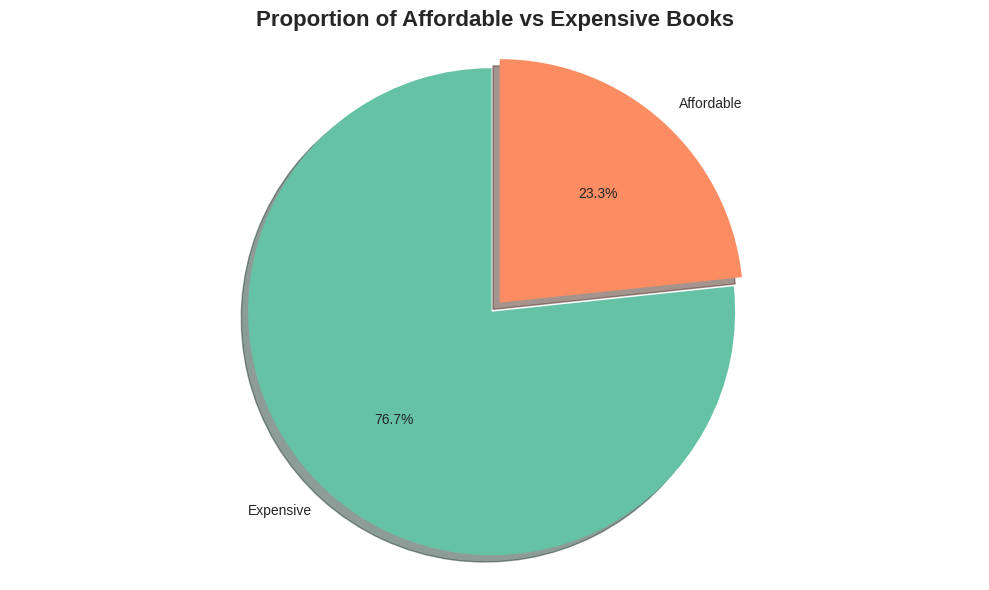

/tmp/ipykernel_23103/1692826610.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_ratings_plot = df.groupby('Price_Category')['Rating_Numeric'].mean().sort_index()


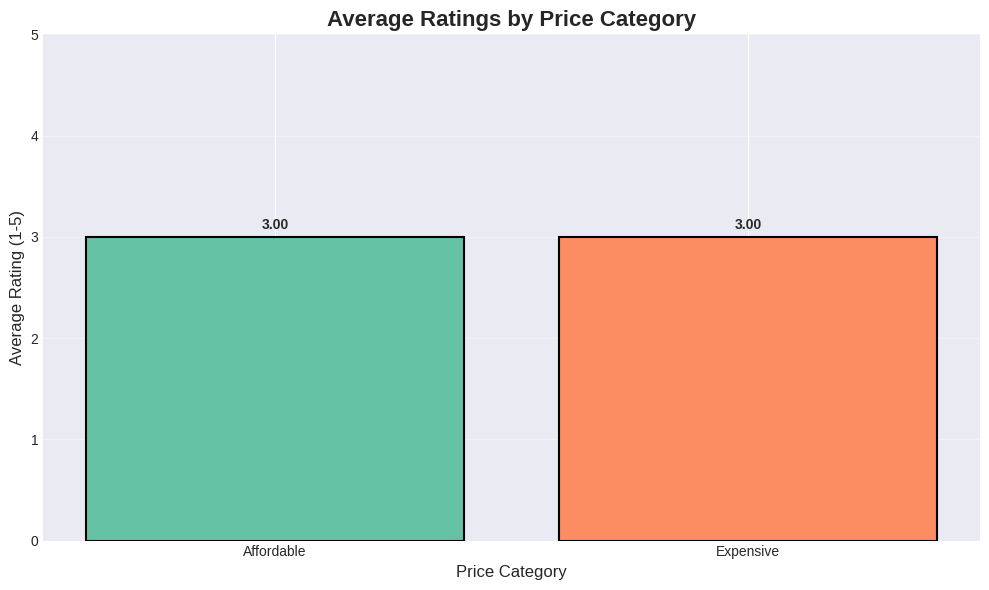

/tmp/ipykernel_23103/1692826610.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price_Category', y='Price_Clean', data=df, palette=['#66c2a5', '#fc8d62'])


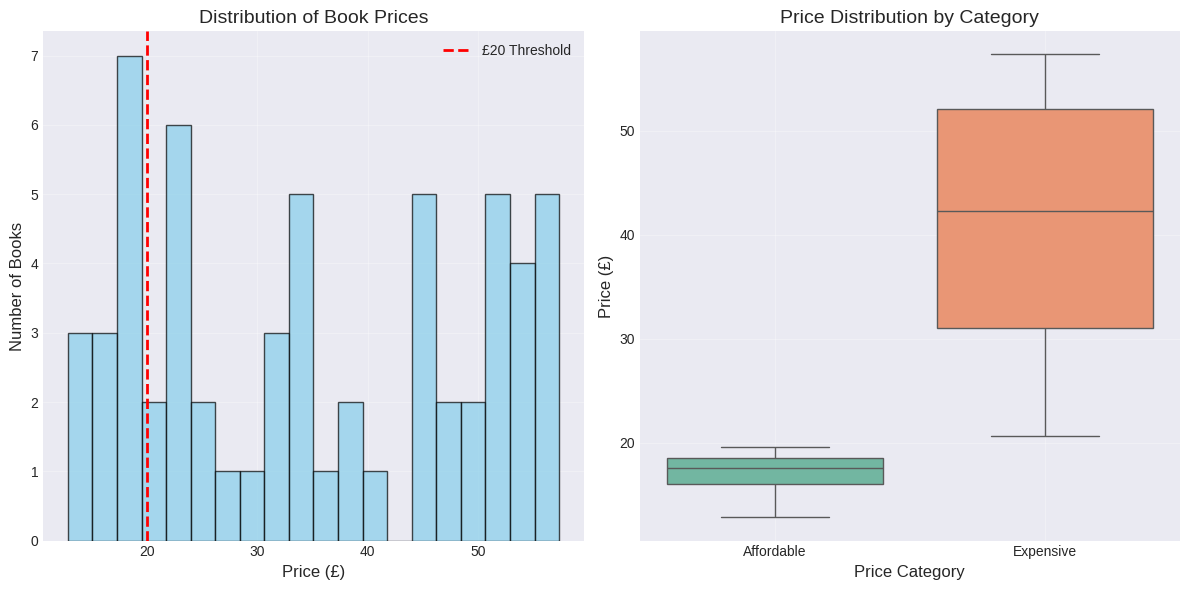

/tmp/ipykernel_23103/1692826610.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_counts = df.groupby(['Price_Category', 'Rating_Numeric']).size().unstack()


<Figure size 1000x600 with 0 Axes>

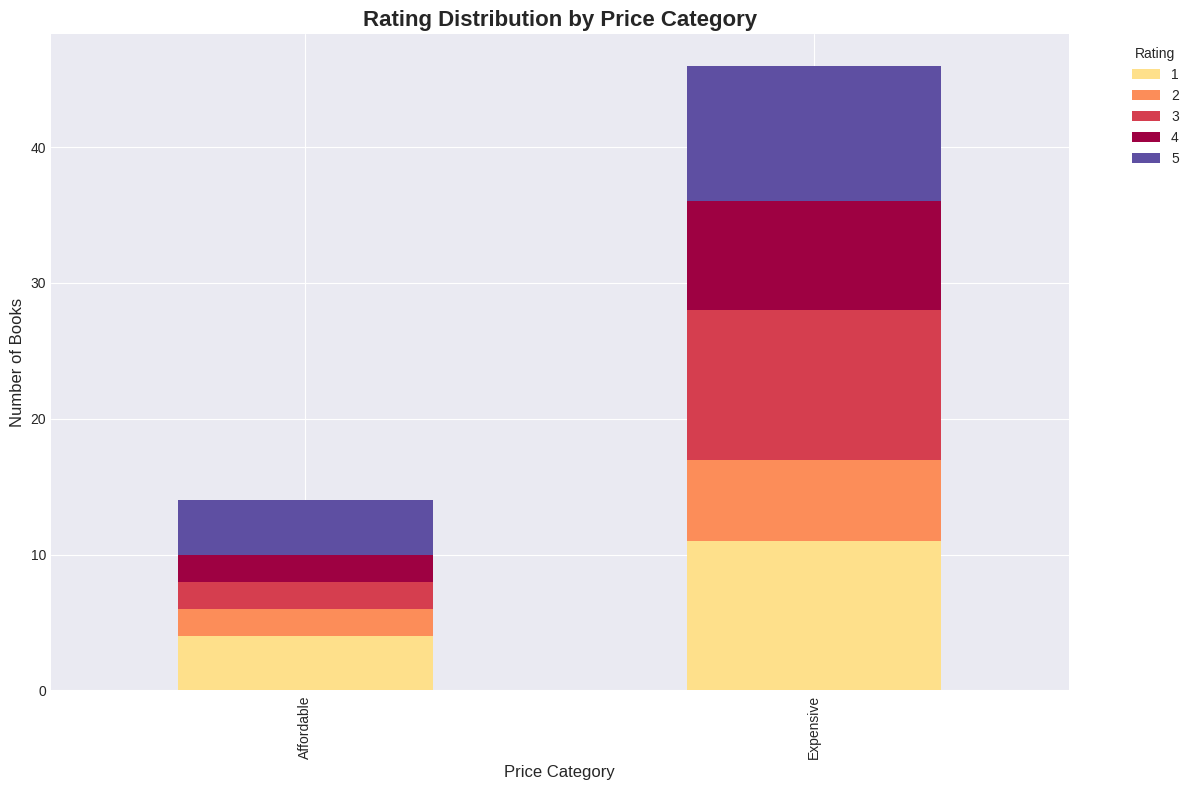

In [7]:
# Create visualizations

# Set figure size for all plots
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Pie chart showing proportion of affordable vs expensive books
plt.figure(figsize=(10, 6))
price_counts = df['Price_Category'].value_counts()
colors = ['#66c2a5', '#fc8d62']  # Green for Affordable, Orange for Expensive
plt.pie(price_counts.values, labels=price_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90, explode=(0.05, 0), shadow=True)
plt.title('Proportion of Affordable vs Expensive Books', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.tight_layout()
plt.show()

# 2. Bar chart of average ratings by category
plt.figure(figsize=(10, 6))
avg_ratings_plot = df.groupby('Price_Category')['Rating_Numeric'].mean().sort_index()
bars = plt.bar(avg_ratings_plot.index, avg_ratings_plot.values, 
               color=['#66c2a5', '#fc8d62'], edgecolor='black', linewidth=1.5)

# Add value labels on top of bars
for bar, value in zip(bars, avg_ratings_plot.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.title('Average Ratings by Price Category', fontsize=16, fontweight='bold')
plt.xlabel('Price Category', fontsize=12)
plt.ylabel('Average Rating (1-5)', fontsize=12)
plt.ylim(0, 5)  # Ratings are on a 1-5 scale
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Additional Visualization: Price Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Price_Clean'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=20, color='red', linestyle='--', linewidth=2, label='£20 Threshold')
plt.title('Distribution of Book Prices', fontsize=14)
plt.xlabel('Price (£)', fontsize=12)
plt.ylabel('Number of Books', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(x='Price_Category', y='Price_Clean', data=df, palette=['#66c2a5', '#fc8d62'])
plt.title('Price Distribution by Category', fontsize=14)
plt.xlabel('Price Category', fontsize=12)
plt.ylabel('Price (£)', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Additional Visualization: Rating Distribution by Category
plt.figure(figsize=(10, 6))
rating_counts = df.groupby(['Price_Category', 'Rating_Numeric']).size().unstack()
rating_counts.plot(kind='bar', stacked=True, color=['#fee08b', '#fc8d59', '#d53e4f', '#9e0142', '#5e4fa2'])
plt.title('Rating Distribution by Price Category', fontsize=16, fontweight='bold')
plt.xlabel('Price Category', fontsize=12)
plt.ylabel('Number of Books', fontsize=12)
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [8]:
# Export the final dataset
output_file = 'books_scraped_cleaned.csv'
df.to_csv(output_file, index=False)
print(f"\n✓ Data exported to '{output_file}'")
print(f"✓ Total records: {len(df)}")

# Save a summary statistics file
summary_stats = {
    'Total_Books': len(df),
    'Average_Price': df['Price_Clean'].mean(),
    'Median_Price': df['Price_Clean'].median(),
    'Affordable_Books': (df['Price_Category'] == 'Affordable').sum(),
    'Expensive_Books': (df['Price_Category'] == 'Expensive').sum(),
    'Average_Rating_Affordable': df[df['Price_Category'] == 'Affordable']['Rating_Numeric'].mean(),
    'Average_Rating_Expensive': df[df['Price_Category'] == 'Expensive']['Rating_Numeric'].mean(),
    'Books_In_Stock': df['In_Stock'].sum()
}

summary_df = pd.DataFrame(list(summary_stats.items()), columns=['Metric', 'Value'])
summary_file = 'books_summary_statistics.csv'
summary_df.to_csv(summary_file, index=False)
print(f"✓ Summary statistics exported to '{summary_file}'")

# Display final summary
print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)
print(f"\nTotal books analyzed: {len(df)}")
print(f"Affordable books (< £20): {(df['Price_Clean'] < 20).sum()} ({(df['Price_Clean'] < 20).mean()*100:.1f}%)")
print(f"Expensive books (≥ £20): {(df['Price_Clean'] >= 20).sum()} ({(df['Price_Clean'] >= 20).mean()*100:.1f}%)")
print(f"\nAverage rating - Affordable books: {df[df['Price_Clean'] < 20]['Rating_Numeric'].mean():.2f}")
print(f"Average rating - Expensive books: {df[df['Price_Clean'] >= 20]['Rating_Numeric'].mean():.2f}")
print(f"\nBooks in stock: {df['In_Stock'].sum()} ({(df['In_Stock'].mean()*100):.1f}%)")


✓ Data exported to 'books_scraped_cleaned.csv'
✓ Total records: 60
✓ Summary statistics exported to 'books_summary_statistics.csv'

FINAL SUMMARY

Total books analyzed: 60
Affordable books (< £20): 14 (23.3%)
Expensive books (≥ £20): 46 (76.7%)

Average rating - Affordable books: 3.00
Average rating - Expensive books: 3.00

Books in stock: 60 (100.0%)
